#### Task 1.1: Data Understanding

Explore the incidents dataset using analytical tools and write a concise "data understanding" report that assesses data quality, the distribution of variables, and pairwise correlations.

#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

Subtasks of Data Understanding:

- Data semantics for each feature not described above and the new ones defined by the team
- Distribution of the variables and statistics
- Assessing data quality (missing values, outliers, duplicated records, errors)
- Variables transformations
- Pairwise correlations and eventual elimination of redundant variables

Nice visualization and insights can be obtained by exploiting the latitude and longitude features ([example](https://plotly.com/python/getting-started/)).

# Task 1.1:

We have to do some data understanding, so we're gonna explore the dataset. We can start with a simple analysis that establish the variable inside our dataset and visualize a bunch of their distibution, type, etc...

In [16]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


# Set a seed for reproducibility
np.random.seed(42)

## Dataset Structure

Let's breakdown the dataset :

- 28 Columns features: Some categorical like date, state etc... Others numerics: n_participants, n_males...
- At the end we've got some notes we could drop, these are not data we can easily manage with statistical tools

In [17]:
# Import the dataset

# Gun incidents data
df_incidents = pd.read_csv('../source/ds/incidents.csv')

# Poverty by state and year
df_poverty = pd.read_csv('../source/ds/povertyByStateYear.csv')

# Year-state-district-house
df_ysdh = pd.read_csv('../source/ds/year_state_district_house.csv')
# Visualize data table

#df_incidents.columns
#df_incidents.dtypes

df_incidents.head()
#df_poverty.head()


/tmp/ipykernel_88611/1905877674.py:4: DtypeWarning:

Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,94.0,33.0,19.0,...,1.0,0.0,0,1,0.0,0.0,1.0,Teen wounded while walking - Security guard at...,Shot - Wounded/Injured,NaN
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,NaN,NaN,62.0,...,1.0,0.0,1,0,0.0,0.0,1.0,shot self after accident,"Shot - Dead (murder, accidental, suicide)",Suicide^
2,2016-11-05,Michigan,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,2.0,NaN,...,NaN,NaN,0,1,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN
4,2030-06-14,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,"Drive-by (car to street, car to car)"


In [18]:
print("--"*50)
df_poverty.info()
print("--"*50)
df_ysdh.info()
print("--"*50)
# make full
df_incidents.info()

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party             

# Data Conversions

- avg_age_participants, min_age_participants, max_age_participants, n_participant_child, n_participant_teen, n_participant_adult: are all object time, convert them to int

In [19]:
# - avg_age_participants, min_age_participants, max_age_participants, n_participant_child, n_participant_teen, n_participant_adult: are all object time, convert them to int
columns_to_convert = [
    'min_age_participants',
    'avg_age_participants',
    'max_age_participants',
    'n_participants_child',
    'n_participants_teen',
    'n_participants_adult'
]

district_to_int = ['state_house_district', 'state_senate_district', 'congressional_district']

# Convert non-numeric values to NaN
df_incidents[columns_to_convert] = df_incidents[columns_to_convert].apply(pd.to_numeric, errors='coerce')

for column in district_to_int:
    df_incidents[column] = df_incidents[column].fillna(0).astype(int)
    
# Fill NaN values with 0
df_incidents[columns_to_convert] = df_incidents[columns_to_convert].fillna(0).astype(int)


df_incidents.dtypes


date                          object
state                         object
city_or_county                object
address                       object
latitude                     float64
longitude                    float64
congressional_district         int64
state_house_district           int64
state_senate_district          int64
participant_age1             float64
participant_age_group1        object
participant_gender1           object
min_age_participants           int64
avg_age_participants           int64
max_age_participants           int64
n_participants_child           int64
n_participants_teen            int64
n_participants_adult           int64
n_males                      float64
n_females                    float64
n_killed                       int64
n_injured                      int64
n_arrested                   float64
n_unharmed                   float64
n_participants               float64
notes                         object
incident_characteristics1     object
i

## Dataset with all feature cross data 

We can join the three dataset for a better understanding, maybe could not be useful if the features are too many.

In [20]:
# Join datasets per state?

# Maybe this is for the next part...

### Getting rid of description data
These type of data can give insights, they contains written description of the incidents, not too accurately and is difficult to create a categorical variable from them. We can drop them for now.

In [21]:

# Example of unusable data

df_incidents['notes'].sample(10)
df_incidents['incident_characteristics1'].sample(10)
df_incidents['incident_characteristics2'].sample(10)

# Drop
df_incidents.drop(['incident_characteristics1', 'incident_characteristics2', 'notes'], axis=1, inplace=True)

df_incidents.head()

# drop state_house_district, state_senate_district, congressional_district? Address is useless for sure

df_incidents_no_district = df_incidents

# Maybe drop state and senate district: state_house_district', 'state_senate_district', 'congressional_district'.
# Convert them from float to int
df_incidents_no_district.drop(['address'], axis=1, inplace=True) 

df_incidents_no_district.head()

df_incidents = df_incidents_no_district

# Data Cleaning
  
- [ ] Check for errors in datasets and correct if possible
- [x] Remove NaNs
- [x] Remove Duplicates
- [x] Remove columns with a lot of NaNs [Note this has to be done before removing NaNs]
- [x] Outliers
- [x] Remove Unnecessary data for statistical analysis
    

<AxesSubplot:>

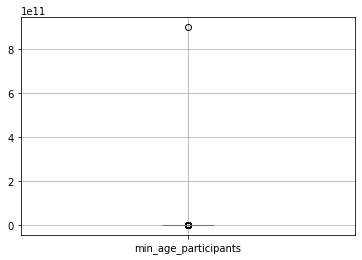

In [51]:
# Exploring dataset errors, there are various type such as: cities located in wrong states, logitude and latiude 
# wrong years in incident dataframe (incidents in 2029 and 2030, maybe they were 2019-2020 since data is until 2020)

# Changing dates in df_incidents

df_incidents['date'] = df_incidents['date'].str.replace('2028', '2018')
df_incidents['date'] = df_incidents['date'].str.replace('2029', '2019')
df_incidents['date'] = df_incidents['date'].str.replace('2030', '2020')

df_incidents['date'].str.split('-').str[0].unique()

# how many data per year..

# Age errors
df_incidents['min_age_participants'].max() # 900000000
df_incidents['min_age_participants'].min() # -1000

# Solution for age errors: replace with mean or median or drop them

# boxplot of min_age_participants
df_incidents.boxplot(column=['min_age_participants'])

# Interestingly when you remove some wrong values or outliers you cant get different
# plot of other variables eg: this boxplot show clearly that age is 1e11, but if you remove some outlier then you get anomalous values around 300.

In [23]:
# Remove NaNs

# How do we define if a columns has a lot of nans?
df_incidents.isna().sum()

#   Let's get the % of nans with respect to the total number of records, if is > 50% we drop the column

for col in df_incidents.columns:
    pct_missing = np.mean(df_incidents[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

    # drop if more than 50% of the data is missing
    if pct_missing > 0.5:
        df_incidents.drop(col, axis=1, inplace=True)


#df_incidents.shape

# Finally deleting all NaNs
df_incidents_nona = df_incidents.dropna()


date - 0%
state - 0%
city_or_county - 0%
latitude - 3%
longitude - 3%
congressional_district - 0%
state_house_district - 0%
state_senate_district - 0%
participant_age1 - 39%
participant_age_group1 - 18%
participant_gender1 - 15%
min_age_participants - 0%
avg_age_participants - 0%
max_age_participants - 0%
n_participants_child - 0%
n_participants_teen - 0%
n_participants_adult - 0%
n_males - 15%
n_females - 15%
n_killed - 0%
n_injured - 0%
n_arrested - 12%
n_unharmed - 12%
n_participants - 0%


In [24]:
# Remove Duplicates: Maybe do this before hand?

df_incidents_nodup = df_incidents_nona.drop_duplicates()

## Mass Shooting

As we can see sometimes the number of people killed or injured it's not an incident it's a mass shooting

Let's remove this by taking into account this definition

```
    FBI Definition: The Federal Bureau of Investigation (FBI) defines a mass shooting as an incident in which four or more people, not including the shooter, are killed. This definition is often used in the United States.
```

In [25]:

#visualize datapoint with more than 20 killed
df_incidents_nodup[df_incidents_nodup['n_killed'] > 20]

# summing n_males and females killed over a total participants score
df_incidents_nodup['n_participants'].sum()/(df_incidents_nodup['n_females'].sum()+df_incidents_nodup['n_males'].sum())

1.049468262347996

# Outliers removal

## Removing also when 'n_participants' is more than 5

This will change the correlation matrix, try to remove this and see what happens

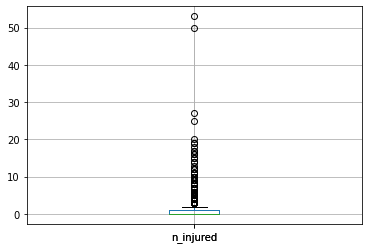

In [26]:
# Let's visualize outliers with a boxplot


df_incidents_nodup.boxplot(column='n_killed')
df_incidents_nodup.boxplot(column='n_injured')

# Remove outliers if n_killed or n_injured > 4
df_incident_no_outliers = df_incidents_nodup[(df_incidents_nodup['n_killed'] < 4) & (df_incidents_nodup['n_injured'] < 4)]

# We have to remove when number of participants is more than 5 also
df_incident_no_outliers = df_incident_no_outliers[df_incident_no_outliers['n_participants'] < 5]


<AxesSubplot:>

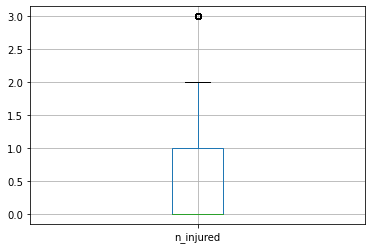

In [27]:
#df_incident_no_outliers.boxplot(column='n_killed')
df_incident_no_outliers.boxplot(column='n_injured')

## Remaining outliers check on the dataset

We will plot all the boxplot relative to the numerical features and check if there are some outliers

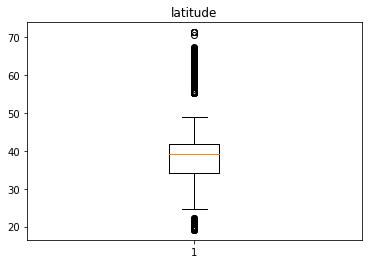

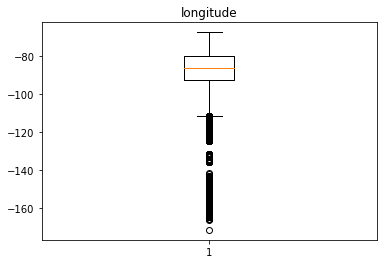

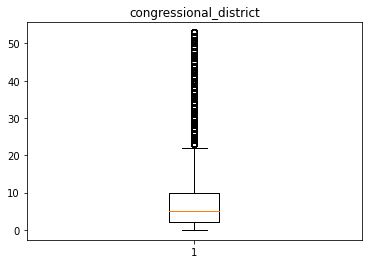

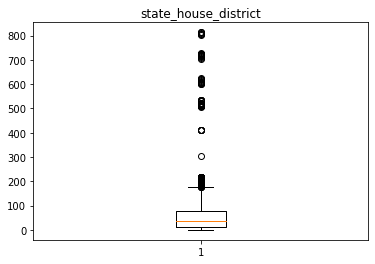

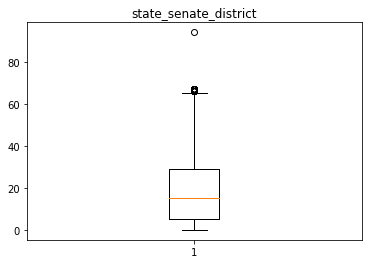

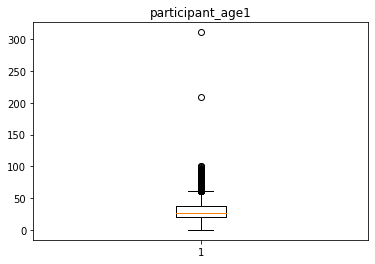

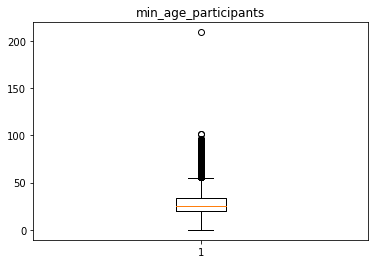

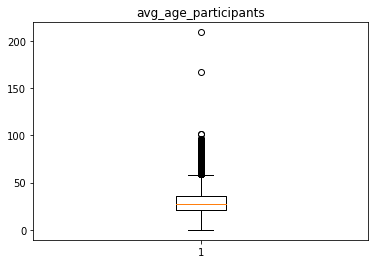

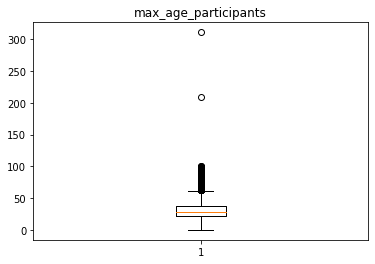

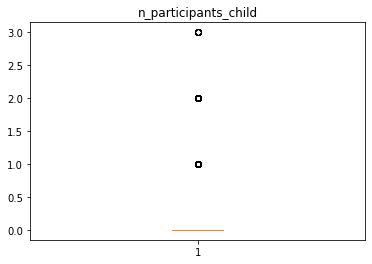

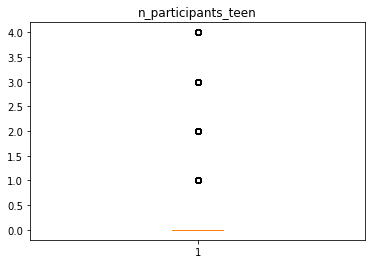

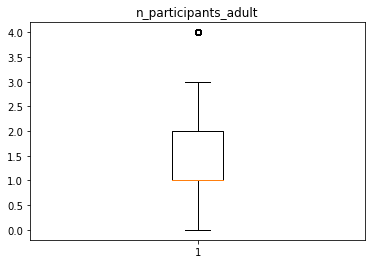

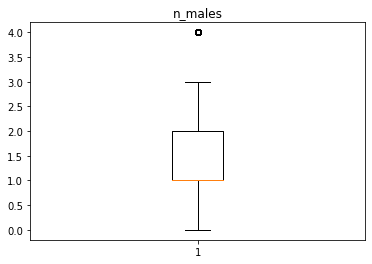

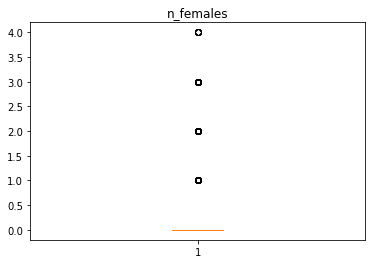

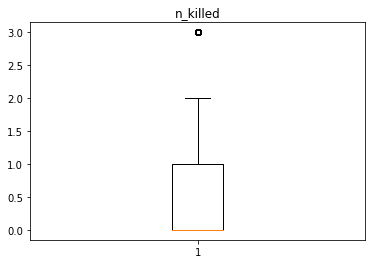

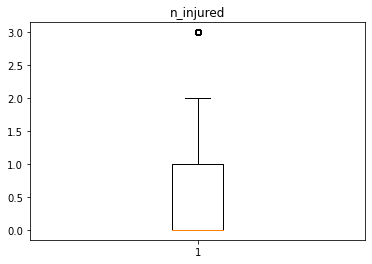

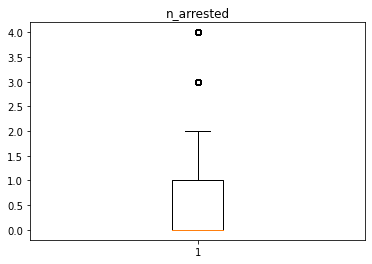

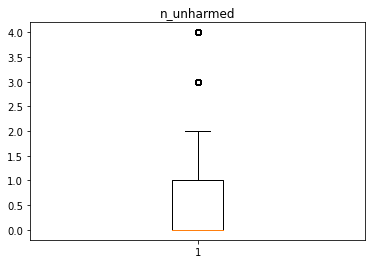

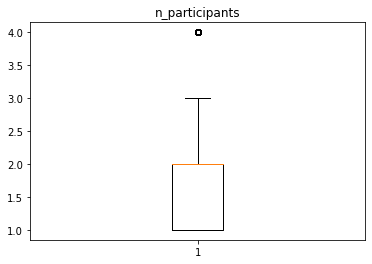

In [28]:
# Plot different subplots of boxplot for each numerical column
import matplotlib.pyplot as plt

# get the numerical columns of the data frame
numerical_columns = df_incident_no_outliers.select_dtypes(include=['float64', 'int64']).columns

# create a boxplot for each numerical column
for column in numerical_columns:
    plt.figure()
    plt.boxplot(df_incident_no_outliers[column])
    plt.title(column)
    plt.show()

# Some insights from outliers plot

How about the min, max ages and average? Why so high? Let's check the data


Absolute minimum age:  0
Absolute maximum age:  311
Minimum of max age:  0
Maximum of max age:  311


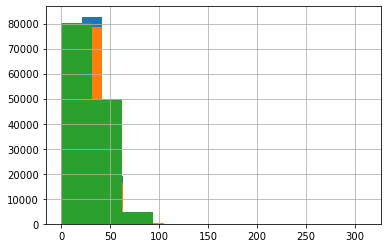

In [29]:
# Let's get hist of age min, max and avg

df_incident_no_outliers['avg_age_participants'].hist()
df_incident_no_outliers['min_age_participants'].hist()
df_incident_no_outliers['max_age_participants'].hist()

# let's get the numerical max and mins
print("Absolute minimum age: ", df_incident_no_outliers['min_age_participants'].min())
print("Absolute maximum age: ", df_incident_no_outliers['max_age_participants'].max())

print("Minimum of max age: ", df_incident_no_outliers['max_age_participants'].min())
print("Maximum of max age: ", df_incident_no_outliers['max_age_participants'].max())


# Correlation on injured-killed

In [30]:
#correlation injured and killed
corr_nk_ninj = df_incident_no_outliers['n_killed'].corr(df_incident_no_outliers['n_injured'])
print("Correlation between n_killed and n_injured: ", corr_nk_ninj)

# Visualizing ration of n_participants on female and male, usually these are almost the same number.
df_incident_no_outliers['n_participants'].sum()/(df_incident_no_outliers['n_females'].sum()+df_incident_no_outliers['n_males'].sum())

Correlation between n_killed and n_injured:  -0.3162311828116497


1.0403005129075025

## Visualize Distributions

From the first we can see that plotting distirbution of n_killed against the number of incidents we can see that in the majority of the incidents people do not die. 

We have a distribution skewed to the left so the asimmetry index must be positive.

### Distribution of Killed People

n_killed
0    68.659964
1    28.372739
2     2.656904
3     0.310393
dtype: float64


 Skewness of n_killed: 1.407094


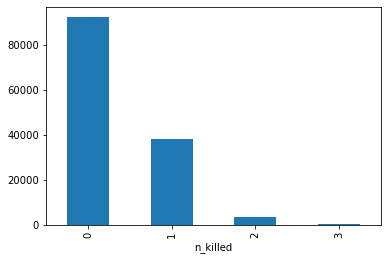

In [31]:
# Using seaborn to visualize the distribution of n_killed 

# In %
print((df_incident_no_outliers.groupby('n_killed').size()/len(df_incident_no_outliers)*100))

df_incident_no_outliers['n_killed'].value_counts().plot(kind='bar')

# PIE CHARTs ARE ILLEGAL
#df_incident_no_outliers['n_killed'].value_counts().plot(kind='pie')

# Asimmetry index is pos
skewness_n_killed = df_incident_no_outliers['n_killed'].skew()
print('\n\n',"Skewness of n_killed: %f" % skewness_n_killed)

### Distribution of Injured People

n_injured
0    58.334571
1    36.155583
2     4.643271
3     0.866576
dtype: float64


 Skewness of n_injured: 1.160691


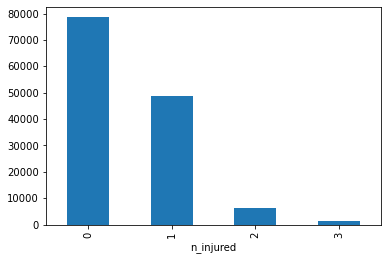

In [32]:

# In %
print((df_incident_no_outliers.groupby('n_injured').size()/len(df_incident_no_outliers)*100))

df_incident_no_outliers['n_injured'].value_counts().plot(kind='bar')

# Asimmetry index is pos
skewness_n_injured = df_incident_no_outliers['n_injured'].skew()
print('\n\n',"Skewness of n_injured: %f" % skewness_n_injured)

### Correlation matrix of all our features

#### Intresting correlations that can be inferred
    -  n_participants and n_males is higly correlated: 0.83 (This will lower if we filter the n_participants > 5, still high tough)
    -  n_participants and n_femals is not: 0.36
    - After converting some feature from object to int-float intresting correlation arises!

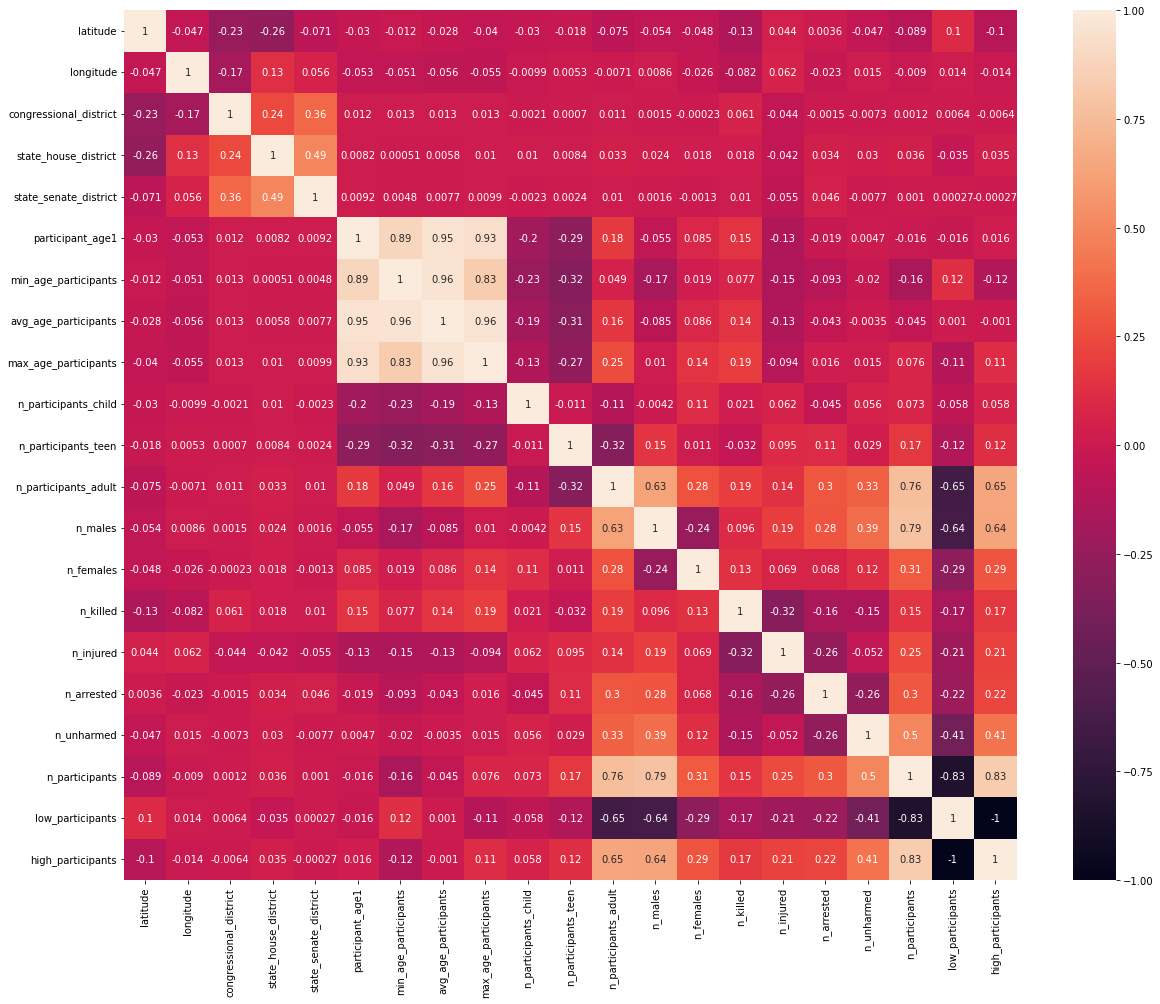

In [45]:
# vector containig all numerical features
numerical_features = df_incident_no_outliers.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 16))  # Adjust the values (width, height) as needed
correlation_matrix_all = df_incident_no_outliers[numerical_features].corr()
sns.heatmap(correlation_matrix_all, annot=True)

# As for the correlation n_males & n_participants we can do statistical significance test, in our case the 
# null hypotesis is that the two variables are independent, we can reject the null hypotesis if the p-value is < 0.05

# Contigency table is used for categorical variable, so we can do a thing like this, take intervals 0-1 and 2-3 of participants
# and make this a categorical variable, then we can do a chi-square test

# adding low_participants column and high_participants column
# need to understand if this make sense or it's redundant.
df_incident_no_outliers['low_participants'] = df_incident_no_outliers['n_participants'].apply(lambda x: 1 if x < 2 else 0)
df_incident_no_outliers['high_participants'] = df_incident_no_outliers['n_participants'].apply(lambda x: 1 if x > 1 else 0)

# And now a little visualization of the chi2 test
# Visualize the result of the test
# print max vaues of n_participants


## Visualizing results of $\chi^2$ test

Wrote a little function that emulates how R show result of a statistical test


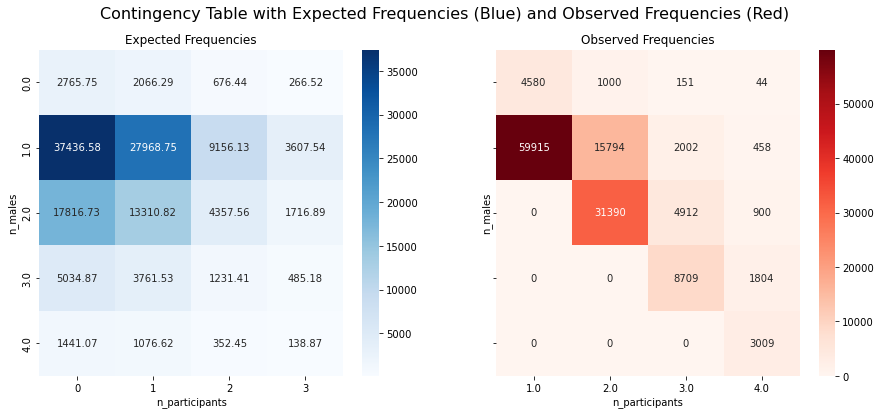

In [34]:

from scipy.stats import chi2_contingency

# get contingency table
contingency_table = pd.crosstab(df_incident_no_outliers['n_males'], df_incident_no_outliers['n_participants'])

# perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table.values)

# Visualize the result of the test
# print max vaues of n_participants

# Heatmap of expected against observed frequencies
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

sns.heatmap(expected, annot=True, fmt='.2f', cmap='Blues', ax=ax1)
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Reds', ax=ax2)

ax1.set_xlabel('n_participants')
ax1.set_ylabel('n_males')
ax1.set_title('Expected Frequencies')

ax2.set_xlabel('n_participants')
ax2.set_title('Observed Frequencies')

plt.suptitle('Contingency Table with Expected Frequencies (Blue) and Observed Frequencies (Red)', fontsize=16)
plt.show()


In [35]:
def print_chi2_results(chi2, p, dof, expected):
    print("Chi-squared test results:")
    print(f"  Chi-squared = {chi2:.20f}")
    print(f"  Degrees of freedom = {dof}")
    print(f"  p-value = {p:.20f}")
    print("  Expected frequencies:")
    for i in range(expected.shape[0]):
        for j in range(expected.shape[1]):
            print(f"    {contingency_table.index[i]} vs {contingency_table.columns[j]}: {expected[i][j]:.2f}")

In [36]:
# Visualizing Chi2
print_chi2_results(chi2, p, dof, expected)

Chi-squared test results:
  Chi-squared = 192280.56118360641994513571
  Degrees of freedom = 12
  p-value = 0.00000000000000000000
  Expected frequencies:
    0.0 vs 1.0: 2765.75
    0.0 vs 2.0: 2066.29
    0.0 vs 3.0: 676.44
    0.0 vs 4.0: 266.52
    1.0 vs 1.0: 37436.58
    1.0 vs 2.0: 27968.75
    1.0 vs 3.0: 9156.13
    1.0 vs 4.0: 3607.54
    2.0 vs 1.0: 17816.73
    2.0 vs 2.0: 13310.82
    2.0 vs 3.0: 4357.56
    2.0 vs 4.0: 1716.89
    3.0 vs 1.0: 5034.87
    3.0 vs 2.0: 3761.53
    3.0 vs 3.0: 1231.41
    3.0 vs 4.0: 485.18
    4.0 vs 1.0: 1441.07
    4.0 vs 2.0: 1076.62
    4.0 vs 3.0: 352.45
    4.0 vs 4.0: 138.87


### Other intresting correlations


In [37]:
# We can correlate other dataset, but later

### Age and Sex distributions

<AxesSubplot:xlabel='n_females'>

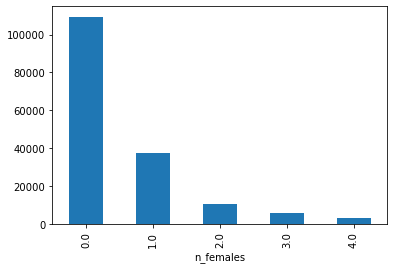

In [38]:
# Print the number of incident of with males and femals plots

# Males incidents
df_incident_no_outliers['n_males'].value_counts().plot(kind='bar')

# Females incidents
df_incident_no_outliers['n_females'].value_counts().plot(kind='bar')


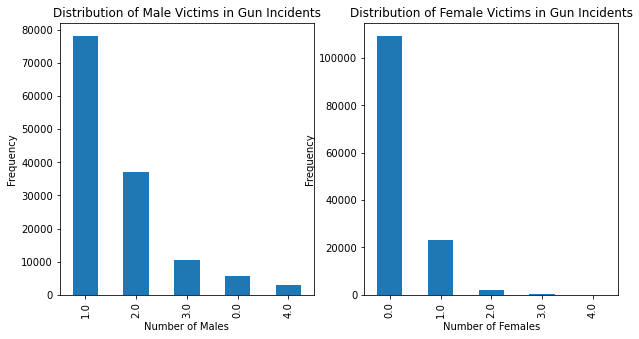

In [39]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the male incidents in the first subplot
df_incident_no_outliers['n_males'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_xlabel('Number of Males')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Male Victims in Gun Incidents')

# Plot the female incidents in the second subplot
df_incident_no_outliers['n_females'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Number of Females')
# Numer of incidents with particular numb of female and male
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Female Victims in Gun Incidents')

# Display the plot
plt.show()

## Distribution of death in each state 


/tmp/ipykernel_88611/4020828899.py:7: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


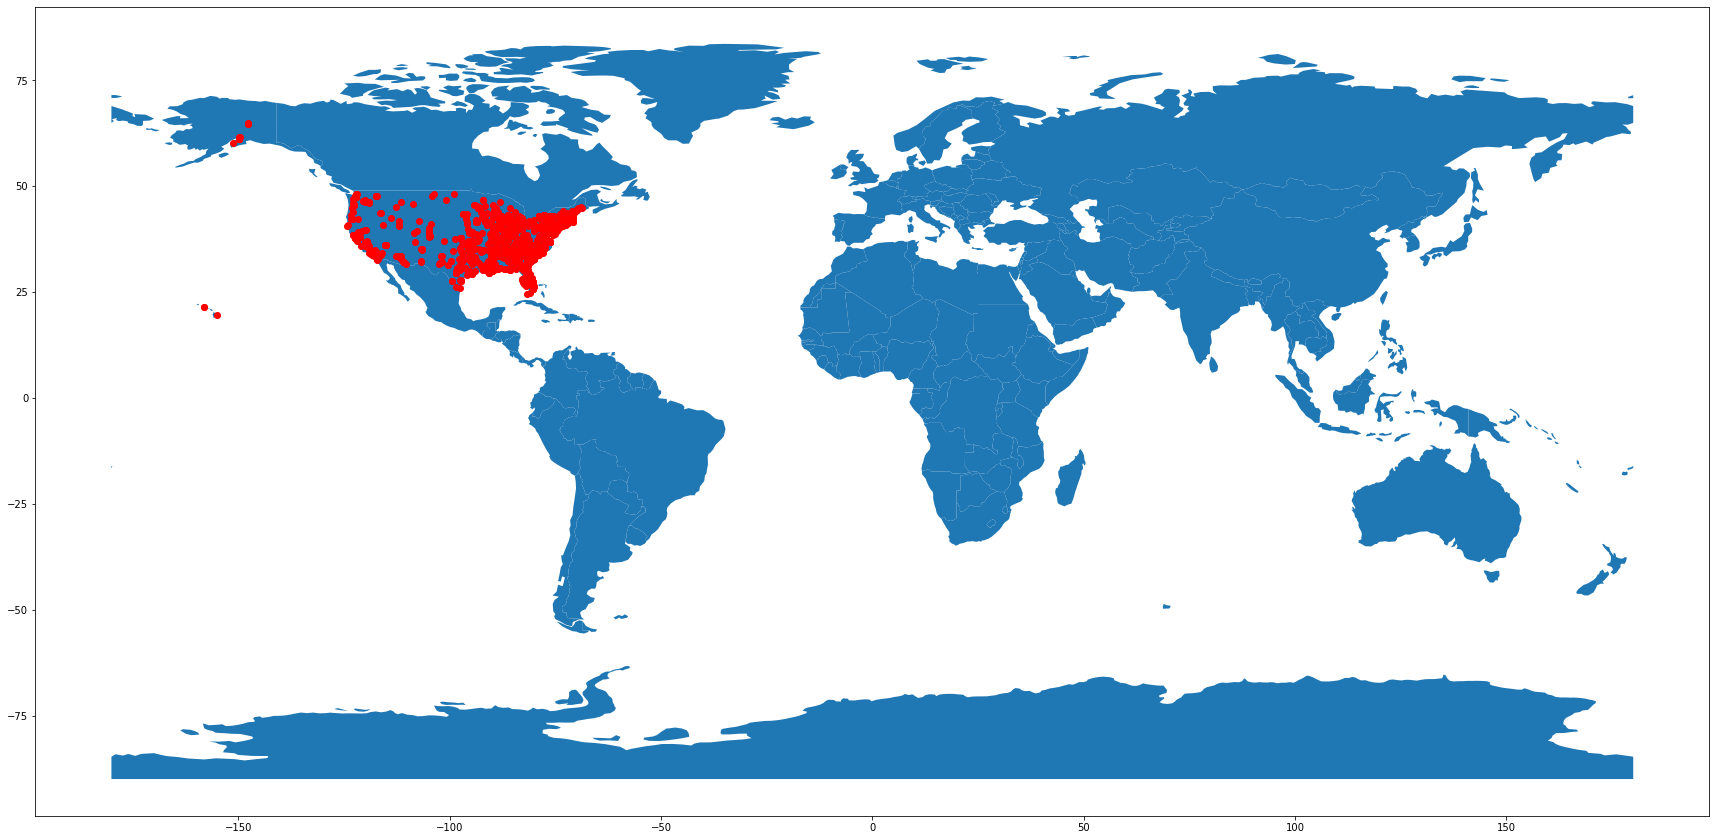

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

#usa_map = gpd.read_file('../map_data/usa-states-census-2014.shp')

# use entire world map
usa_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# show map



usa_map.plot(figsize=(30,40))

# Draw red point for each latitude and longitude on df_incidents for 50 sampled incidents

sample_incidents = df_incidents_nodup.sample(len(df_incidents_nodup)//100)

for index, row in sample_incidents.iterrows():
    plt.plot(row['longitude'], row['latitude'], 'ro')
    

usa_map.head()


In [41]:

len(df_incidents_nodup['state'].unique())
# We have 49 states in the data but there are 50, we lack Alaska and Hawaii american states why?

df_incidents_nodup['state'].unique()

array(['Indiana', 'Pennsylvania', 'North Carolina', 'Louisiana',
       'Virginia', 'Oklahoma', 'New York', 'Missouri', 'California',
       'Texas', 'Illinois', 'Michigan', 'South Carolina', 'Georgia',
       'Massachusetts', 'Arkansas', 'Connecticut', 'Rhode Island',
       'Tennessee', 'New Jersey', 'Washington', 'Maine', 'Florida',
       'Ohio', 'Maryland', 'South Dakota', 'Arizona', 'Nevada',
       'Wisconsin', 'Alabama', 'Mississippi', 'Kansas', 'Iowa', 'Oregon',
       'West Virginia', 'District of Columbia', 'Wyoming', 'Nebraska',
       'Colorado', 'Kentucky', 'Utah', 'Minnesota', 'New Mexico',
       'Alaska', 'Hawaii', 'Delaware', 'New Hampshire', 'Montana',
       'Idaho', 'North Dakota', 'Vermont'], dtype=object)

51


<AxesSubplot:ylabel='Frequency'>

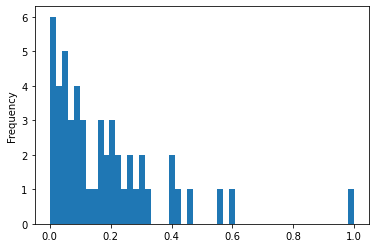

In [42]:
# Trying to plot a colormap or heatmap 

state_incidents = {}

usa_incidents_map = gpd.read_file('../map_data/usa-states-census-2014.shp')

# Counting the number of incidents per state
for state in sample_incidents['state'].unique():
    state_incidents[state] = len(sample_incidents[sample_incidents['state'] == state])


max_incidents = max(state_incidents.values())
min_incidents = min(state_incidents.values())

for state in state_incidents:
    state_incidents[state] = (state_incidents[state] - min_incidents) / (max_incidents - min_incidents)
    
# Convert in dataframe and divide key and value in two columns state and score
state_incidents_df = pd.DataFrame.from_dict(state_incidents, orient='index')
state_incidents_df.reset_index(inplace=True)
state_incidents_df.columns = ['state', 'score']


# histogram of the scores
# why 46? explore this
print(len(state_incidents_df['state'].unique()))
state_incidents_df['score'].plot(kind='hist', bins=len(state_incidents_df['state'].unique()))


# To get a color map we need to merge the map geometric data dataframe with state column (need to find or build it) with our dataset


## This is from sampled data, be careful!

{'Georgia': 0.3125,
 'Massachusetts': 0.22916666666666666,
 'Ohio': 0.3958333333333333,
 'Illinois': 1.0,
 'California': 0.6041666666666666,
 'Wisconsin': 0.2152777777777778,
 'Texas': 0.5555555555555556,
 'Arizona': 0.08333333333333333,
 'Pennsylvania': 0.4305555555555556,
 'Indiana': 0.20833333333333334,
 'Kansas': 0.10416666666666667,
 'Maryland': 0.25,
 'Missouri': 0.2708333333333333,
 'Iowa': 0.14583333333333334,
 'Arkansas': 0.1111111111111111,
 'New York': 0.4583333333333333,
 'West Virginia': 0.027777777777777776,
 'North Carolina': 0.2569444444444444,
 'New Jersey': 0.2013888888888889,
 'Florida': 0.4097222222222222,
 'South Carolina': 0.2986111111111111,
 'Tennessee': 0.2847222222222222,
 'New Mexico': 0.041666666666666664,
 'Louisiana': 0.3263888888888889,
 'New Hampshire': 0.020833333333333332,
 'North Dakota': 0.013888888888888888,
 'Maine': 0.05555555555555555,
 'Oklahoma': 0.10416666666666667,
 'Michigan': 0.1597222222222222,
 'Kentucky': 0.125,
 'Alabama': 0.15972222222

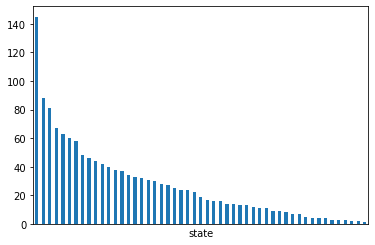

In [43]:
#sample_incidents['city_or_county'].groupby(sample_incidents['state']).value_counts().plot(kind='bar')
sample_incidents['state'].value_counts().plot(kind='bar')
# omit x axis name
plt.xticks([])

state_incidents

In [44]:
#sum arrested, injured, killed and compare to n_participants to a random record
sample_incidents['n_participants'] == sample_incidents['n_arrested'] + sample_incidents['n_injured'] + sample_incidents['n_killed']


#sample_incidents['n_participants'][88251] == sample_incidents['n_arrested'][88251] + sample_incidents['n_injured'][88251] + sample_incidents['n_killed'][88251]

105465     True
215583     True
136865     True
137398    False
216315    False
          ...  
149203     True
72464      True
14675      True
108574     True
223229     True
Length: 1394, dtype: bool